In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import os


In [ ]:
df_augmented = pd.read_csv('/content/drive/MyDrive/DL project/labels/augmented.csv')
df_augmented.head()
print(df_augmented['Condition'].value_counts())
print(df_augmented.shape)


Condition
lung fibrosis       144
asthma              140
copd                140
healthy             140
pneumonia           140
urti                138
bronchiectasis      128
bronchiolitis       104
plueral effusion    100
bronchitis           96
Name: count, dtype: int64
(1270, 6)


In [ ]:
!pip install librosa numpy pandas scikit-learn matplotlib



In [ ]:
import pandas as pd
import os

# Load metadata
metadata = df_augmented

# Display metadata structure
print(metadata.head())

# Check available audio files
audio_folder = "/content/drive/MyDrive/DL project/Merged and preprocessed audio/Final_audio"
audio_files = [f for f in os.listdir(audio_folder) if f.endswith('.wav')]

print(f"Total audio files: {len(audio_files)}")


                                     Audio File Name   Age Gender Location  \
0  DP34_heart failure,Crep,P R M,78,F_2_standardi...  50.0      F  P L L R   
1     BP65_asthma,E W,P R L ,60,F_1_standardized.wav  60.0      F    P R L   
2     BP104_Asthma,E W,P L U,45,F_1_standardized.wav  45.0      F    P L U   
3      EP12_Asthma,E W,P L L,50,F_1_standardized.wav  50.0      F    P L L   
4        DP77_Asthma,E W,A R L,40,M_standardized.wav  40.0      M    A R L   

  Sound Type Condition  
0      I E W    asthma  
1        E W    asthma  
2        E W    asthma  
3        E W    asthma  
4        E W    asthma  
Total audio files: 1161


In [ ]:
import librosa
import numpy as np

def extract_features(file_path):
    try:
        # Load audio file
        y, sr = librosa.load(file_path, sr=None)

        # Mel-Spectrogram
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)
        mel_spec_mean = np.mean(mel_spec, axis=1)

        # MFCC
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfcc_mean = np.mean(mfcc, axis=1)

        # Chromagram
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        chroma_mean = np.mean(chroma, axis=1)

        # Zero-Crossing Rate
        zcr = librosa.feature.zero_crossing_rate(y)
        zcr_mean = np.mean(zcr)

        # Spectral Contrast
        spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
        spectral_contrast_mean = np.mean(spectral_contrast, axis=1)

        # Combine features into a single array
        features = np.concatenate((mel_spec_mean, mfcc_mean, chroma_mean, [zcr_mean], spectral_contrast_mean))
        return features
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None


In [ ]:
from tqdm import tqdm

# Create an empty list to store features and corresponding labels
feature_list = []
labels = []

# Iterate over metadata to extract features
for i, row in tqdm(metadata.iterrows(), total=metadata.shape[0]):
    file_name = os.path.join(audio_folder, row['Audio File Name'])  # Update this key to match your CSV column
    if os.path.exists(file_name):
        features = extract_features(file_name)
        if features is not None:
            feature_list.append(features)
            labels.append(row['Condition'])  # Update this key to match your CSV column

# Convert to NumPy arrays
X = np.array(feature_list)
y = np.array(labels)

print(f"Feature matrix shape: {X.shape}")


  0%|          | 1/1270 [00:00<03:41,  5.72it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
100%|██████████| 1270/1270 [13:06<00:00,  1.61it/s]

Feature matrix shape: (1270, 161)


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Features normalized.")


Features normalized.


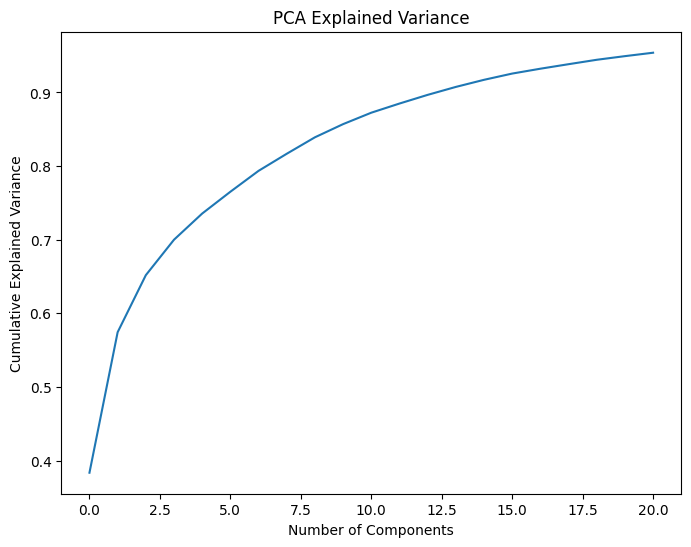

Reduced feature matrix shape: (1270, 21)


In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Perform PCA
pca = PCA(n_components=0.95)  # Retain 95% variance
X_pca = pca.fit_transform(X_scaled)

# Plot explained variance
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.show()

print(f"Reduced feature matrix shape: {X_pca.shape}")


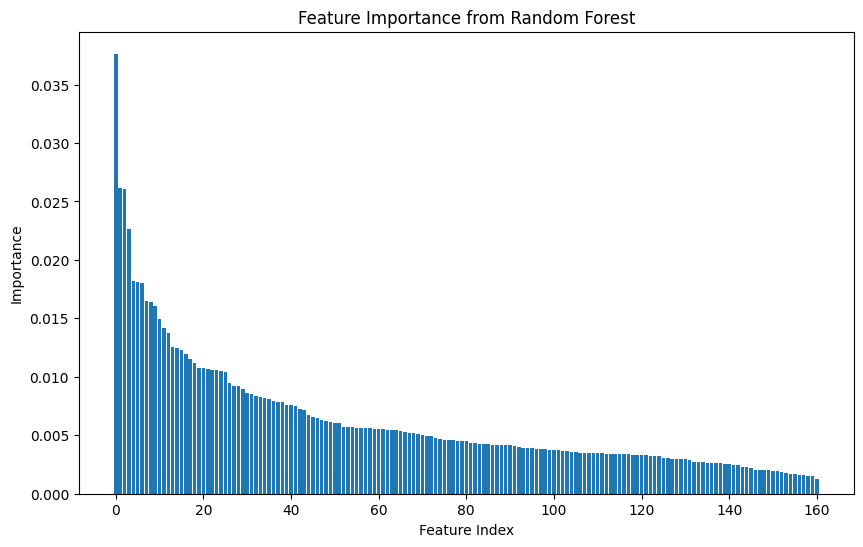

Feature 160: Importance 0.03764215925209249
Feature 0: Importance 0.02612436628204535
Feature 154: Importance 0.026077522939174307
Feature 1: Importance 0.022647513797277377
Feature 147: Importance 0.01822078848408405
Feature 148: Importance 0.01809212903256647
Feature 128: Importance 0.018005840528622686
Feature 156: Importance 0.01647968141275656
Feature 140: Importance 0.016407736713483865
Feature 159: Importance 0.016067927335501855


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train a Random Forest model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# Get feature importance
importances = rf_model.feature_importances_

# Sort feature importance
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), importances[indices])
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.title("Feature Importance from Random Forest")
plt.show()

# Print top features
for i in indices[:10]:  # Change number for more features
    print(f"Feature {i}: Importance {importances[i]}")


In [ ]:
top_features = indices[:10]  # Select top 10 features
X_top = X_scaled[:, top_features]

# Train and evaluate with selected features
rf_model.fit(X_train[:, top_features], y_train)
print(f"Model accuracy with top features: {rf_model.score(X_test[:, top_features], y_test):.2f}")


Model accuracy with top features: 0.81


In [ ]:
feature_mapping = {
    "Mel-Spectrogram": range(0, 128),
    "MFCC": range(128, 141),
    "Chromagram": range(141, 153),
    "Spectral Contrast": range(154, 161),
    "ZCR": [161],
    "RMS": [162]
}


In [ ]:
def get_feature_name(feature_index, mapping):
    for feature_name, indices in mapping.items():
        if feature_index in indices:
            return feature_name
    return "Unknown"

# Print feature names for the top features
for i in indices[:50]:
    feature_name = get_feature_name(i, feature_mapping)
    print(f"Feature {i}: Importance {importances[i]} - {feature_name}")


Feature 160: Importance 0.03764215925209249 - Spectral Contrast
Feature 0: Importance 0.02612436628204535 - Mel-Spectrogram
Feature 154: Importance 0.026077522939174307 - Spectral Contrast
Feature 1: Importance 0.022647513797277377 - Mel-Spectrogram
Feature 147: Importance 0.01822078848408405 - Chromagram
Feature 148: Importance 0.01809212903256647 - Chromagram
Feature 128: Importance 0.018005840528622686 - MFCC
Feature 156: Importance 0.01647968141275656 - Spectral Contrast
Feature 140: Importance 0.016407736713483865 - MFCC
Feature 159: Importance 0.016067927335501855 - Spectral Contrast
Feature 158: Importance 0.014913923105764693 - Spectral Contrast
Feature 131: Importance 0.014157563962340556 - MFCC
Feature 129: Importance 0.013724634133360376 - MFCC
Feature 157: Importance 0.012534540322010373 - Spectral Contrast
Feature 149: Importance 0.012427471701645569 - Chromagram
Feature 146: Importance 0.01227349536246455 - Chromagram
Feature 139: Importance 0.011964674553738857 - MFCC
Fe

In [ ]:
import librosa
import numpy as np

def extract_feature_means(file_path, sr=44100, n_mels=128, n_mfcc=13):
    """
    Extracts the mean of extended features for CNN input.
    Args:
        file_path: Path to the audio file.
        sr: Sampling rate.
        n_mels: Number of Mel bands.
        n_mfcc: Number of MFCC coefficients.
    Returns:
        features: 1D array of concatenated feature means.
    """
    try:
        # Load audio file
        y, sr = librosa.load(file_path, sr=sr)
        y = librosa.util.normalize(y)

        # Mel-Spectrogram
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        mel_spec_mean = np.mean(mel_spec_db, axis=1)

        # MFCC and derivatives
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        mfcc_mean = np.mean(mfcc, axis=1)
        mfcc_delta = librosa.feature.delta(mfcc)
        mfcc_delta_mean = np.mean(mfcc_delta, axis=1)
        mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
        mfcc_delta2_mean = np.mean(mfcc_delta2, axis=1)

        # Chromagram
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        chroma_mean = np.mean(chroma, axis=1)

        # Spectral Contrast
        spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
        spectral_contrast_mean = np.mean(spectral_contrast, axis=1)

        # Spectral Rolloff
        spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.85)
        spectral_rolloff_mean = np.mean(spectral_rolloff)

        # Combine feature means into a single array
        features = np.concatenate((
            mel_spec_mean,               # Mean of Mel-Spectrogram
            mfcc_mean,                   # Mean of MFCC
            mfcc_delta_mean,             # Mean of MFCC Delta
            mfcc_delta2_mean,            # Mean of MFCC Delta-Delta
            chroma_mean,                 # Mean of Chromagram
            spectral_contrast_mean,      # Mean of Spectral Contrast
            [spectral_rolloff_mean]      # Mean of Spectral Rolloff
        ))
        return features
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None


In [ ]:
from tqdm import tqdm

# Create an empty list to store features and corresponding labels
feature_list = []
labels = []

# Iterate over metadata to extract features
for i, row in tqdm(metadata.iterrows(), total=metadata.shape[0]):
    file_name = os.path.join(audio_folder, row['Audio File Name'])  # Update this key to match your CSV column
    if os.path.exists(file_name):
        features = extract_feature_means(file_name)
        if features is not None:
            feature_list.append(features)
            labels.append(row['Condition'])  # Update this key to match your CSV column

# Convert to NumPy arrays
X = np.array(feature_list)
y = np.array(labels)

print(f"Feature matrix shape: {X.shape}")


  0%|          | 1/1270 [00:00<15:46,  1.34it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
100%|██████████| 1270/1270 [05:43<00:00,  3.70it/s]

Feature matrix shape: (1270, 187)


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Features normalized.")

Features normalized.


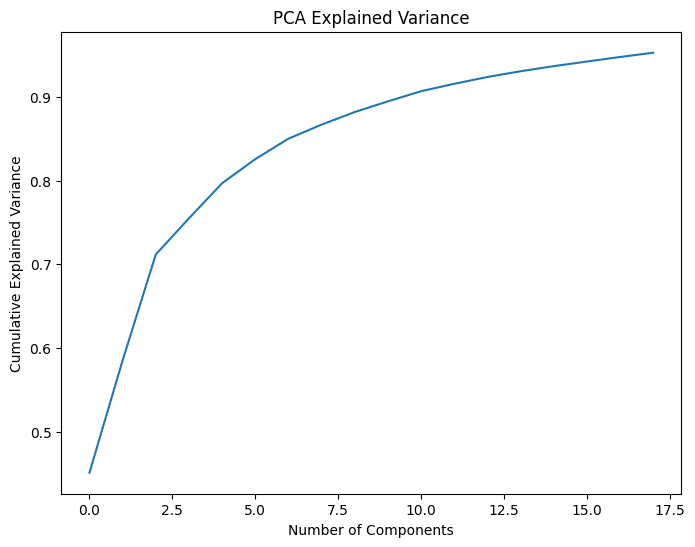

Reduced feature matrix shape: (1270, 18)


In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Perform PCA
pca = PCA(n_components=0.95)  # Retain 95% variance
X_pca = pca.fit_transform(X_scaled)

# Plot explained variance
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.show()

print(f"Reduced feature matrix shape: {X_pca.shape}")


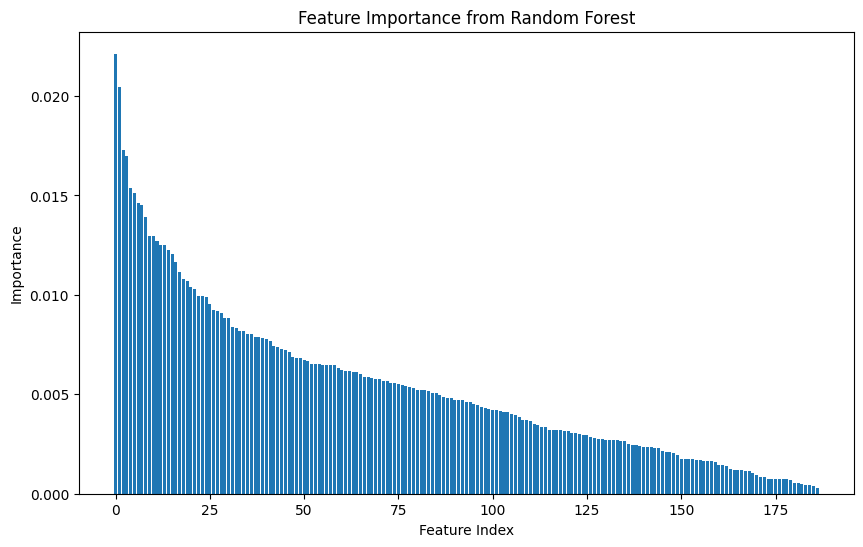

Feature 142: Importance 0.022129590242377047
Feature 179: Importance 0.02045944103729814
Feature 175: Importance 0.017288347629297252
Feature 141: Importance 0.01701065836423367
Feature 3: Importance 0.015375223684307646
Feature 144: Importance 0.015128874331327381
Feature 183: Importance 0.014646117138086225
Feature 185: Importance 0.014508440993390201
Feature 174: Importance 0.01389533728001821
Feature 4: Importance 0.012971703173056372


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train a Random Forest model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# Get feature importance
importances = rf_model.feature_importances_

# Sort feature importance
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), importances[indices])
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.title("Feature Importance from Random Forest")
plt.show()

# Print top features
for i in indices[:10]:  # Change number for more features
    print(f"Feature {i}: Importance {importances[i]}")


In [ ]:
top_features = indices[:10]  # Select top 10 features
X_top = X_scaled[:, top_features]

# Train and evaluate with selected features
rf_model.fit(X_train[:, top_features], y_train)
print(f"Model accuracy with top features: {rf_model.score(X_test[:, top_features], y_test):.2f}")


Model accuracy with top features: 0.79


In [ ]:
feature_mapping = {
    "Mel-Spectrogram": range(0, 128),              # Indices 0–127
    "MFCC": range(128, 141),                       # Indices 128–140
    "MFCC Delta": range(141, 154),                 # Indices 141–153
    "MFCC Delta-Delta": range(154, 167),           # Indices 154–166
    "Chromagram": range(167, 179),                 # Indices 167–178
    "Spectral Contrast": range(179, 186),          # Indices 179–185
    "Spectral Rolloff": [186]                      # Index 186
}


In [ ]:
def map_feature_to_type(feature_index, mapping):
    for feature_name, indices in mapping.items():
        if feature_index in indices:
            return feature_name
    return "Unknown"


In [ ]:
# Example: Map the top features from your result
top_features = [
    (142, 0.022129590242377047),
    (179, 0.02045944103729814),
    (175, 0.017288347629297252),
    (141, 0.01701065836423367),
    (3, 0.015375223684307646),
    (144, 0.015128874331327381),
    (183, 0.014646117138086225),
    (185, 0.014508440993390201),
    (174, 0.01389533728001821),
    (4, 0.012971703173056372)
]

# Print feature types and their importance
for feature_index, importance in top_features:
    feature_name = map_feature_to_type(feature_index, feature_mapping)
    print(f"Feature {feature_index}: Importance {importance} - {feature_name}")


Feature 142: Importance 0.022129590242377047 - MFCC Delta
Feature 179: Importance 0.02045944103729814 - Spectral Contrast
Feature 175: Importance 0.017288347629297252 - Chromagram
Feature 141: Importance 0.01701065836423367 - MFCC Delta
Feature 3: Importance 0.015375223684307646 - Mel-Spectrogram
Feature 144: Importance 0.015128874331327381 - MFCC Delta
Feature 183: Importance 0.014646117138086225 - Spectral Contrast
Feature 185: Importance 0.014508440993390201 - Spectral Contrast
Feature 174: Importance 0.01389533728001821 - Chromagram
Feature 4: Importance 0.012971703173056372 - Mel-Spectrogram


In [ ]:
def get_feature_name(feature_index, mapping):
    for feature_name, indices in mapping.items():
        if feature_index in indices:
            return feature_name
    return "Unknown"

# Print feature names for the top features
for i in indices[:50]:
    feature_name = get_feature_name(i, feature_mapping)
    print(f"Feature {i}: Importance {importances[i]} - {feature_name}")

Feature 142: Importance 0.022129590242377047 - MFCC Delta
Feature 179: Importance 0.02045944103729814 - Spectral Contrast
Feature 175: Importance 0.017288347629297252 - Chromagram
Feature 141: Importance 0.01701065836423367 - MFCC Delta
Feature 3: Importance 0.015375223684307646 - Mel-Spectrogram
Feature 144: Importance 0.015128874331327381 - MFCC Delta
Feature 183: Importance 0.014646117138086225 - Spectral Contrast
Feature 185: Importance 0.014508440993390201 - Spectral Contrast
Feature 174: Importance 0.01389533728001821 - Chromagram
Feature 4: Importance 0.012971703173056372 - Mel-Spectrogram
Feature 184: Importance 0.012964858179945122 - Spectral Contrast
Feature 5: Importance 0.012731672344759526 - Mel-Spectrogram
Feature 147: Importance 0.012502060944421288 - MFCC Delta
Feature 2: Importance 0.012492944790453148 - Mel-Spectrogram
Feature 182: Importance 0.012246719481575132 - Spectral Contrast
Feature 146: Importance 0.012059559587030724 - MFCC Delta
Feature 176: Importance 0.01

So the top features we got are MFCC delta, spectral contrast, Mel-spectogram, MFCC, Chromagram